In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator
import numpy as np
import seaborn as sns
import astropy.units as u
import astropy.constants as const
import pandas as pd
from scipy.integrate import quad_vec, cumulative_trapezoid
from scipy.special import spherical_jn
from scipy.interpolate import UnivariateSpline
from collections.abc import Iterable
from aidm.const import *
import aidm.experiments as x
from astropy.table import Table
from aidm.cross_sections import cs_limit, cs_to_axion
from aidm.dm_velocity import vdm
from aidm.rate import rate

## set fig params|
sns.set_context("paper")
sns.set_style('ticks')
sns.set_palette('colorblind')
figparams = {
        'text.latex.preamble': [r'\usepackage{amsmath}', r'\boldmath'],
        'text.usetex':True,
        'axes.labelsize':20.,
        'xtick.labelsize':16,
        'ytick.labelsize':16,
        'figure.figsize':[10., 8.],
        'font.family':'DejaVu Sans',
        'legend.fontsize':18}
plt.rcParams.update(figparams)
cs = plt.rcParams['axes.prop_cycle'].by_key()['color']
import matplotlib
matplotlib.use('Agg')
%matplotlib inline



## set global params
RECALC_LIMITS = False
## following array also sets colors, which is why there are Nones
exps = ['GDM', 'MAQRO', 'Pino', None, 'BECCAL', None, None, None, None, 'Stanford']
data_dir = '../data/'



u.set_enabled_equivalencies(u.mass_energy())

/Users/kpardo/opt/miniconda3/lib/python3.10/_collections_abc.py:994: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [2]:
## FORMAT TICK LABELS FOR CARTOON
## from: https://stackoverflow.com/questions/40642061/how-to-set-axis-ticks-in-multiples-of-pi-python-matplotlib

def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\frac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\frac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\frac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

class Multiple:
    def __init__(self, denominator=2, number=np.pi, latex='\pi'):
        self.denominator = denominator
        self.number = number
        self.latex = latex

    def locator(self):
        return plt.MultipleLocator(self.number / self.denominator)

    def formatter(self):
        return plt.FuncFormatter(multiple_formatter(self.denominator, self.number, self.latex))

In [3]:
## load 5th force + stellar constraints + define conversion to sigma_n
ffmphi, ffyn = np.loadtxt(data_dir+'5thforceynvsmPhiGeV.dat', unpack=True)
rgbmphi, rgbyn = np.loadtxt(data_dir+'RGStarsynVSmPhiGeV.dat', unpack=True)
hbmphi, hbyn = np.loadtxt(data_dir+'HbStarsynVSmPhiGeV.dat', unpack=True)
snmphi, snyn = np.loadtxt(data_dir+'SN1987ynVSmPhiGeV.dat', unpack=True)

ffmphi = (ffmphi*u.GeV).to(u.MeV)
rgbmphi = (rgbmphi*u.GeV).to(u.MeV)
hbmphi = (hbmphi*u.GeV).to(u.MeV)
snmphi = (snmphi*u.GeV).to(u.MeV)

def yn_to_sigman(yn, mx, mphi, yx=np.sqrt(4*np.pi), mux=None, vdm=vdm):
    if mux == None:
        mux = mx
    massfac = mux**2/(mphi**2+vdm**2*mx**2)**2
    sig_in_invGeV = (yn**2 * yx**2 * massfac * 1. / (4 * np.pi)).to(1./u.GeV**2)
    return (sig_in_invGeV*1./lp**2).to(u.cm**(2))


## load other constraints
## NOTE: He curves from Knapen+ 2017 assume Omegax = OmegaDM. Need to re-scale!
HeNRdat = pd.read_csv(data_dir+'NR.txt', names=['mx', 'sigma'], delimiter='\s+').sort_values(by='mx')
Hephodat = pd.read_csv(data_dir+'phonon2.txt', names=['mx', 'sigma'], delimiter='\s+').sort_values(by='mx')
Xe1T = pd.read_csv(data_dir+'XENON1T18.dat', names=['mx', 'sigma'], delimiter='\s+') ## mx in GeV, sig in cm^2
XenT = pd.read_csv(data_dir+'Xenon_nT.dat', names=['mx', 'sigma'], delimiter='\s+') ## mx in GeV, sig in cm^2

heavy_HeNRdat = pd.read_csv(data_dir+'SFHeNRMassive.dat', names=['mx', 'sigma'], delimiter='\s+').sort_values(by='mx')
heavy_Hephodat = pd.read_csv(data_dir+'SFHeMassive.dat', names=['mx', 'sigma'], delimiter='\s+').sort_values(by='mx')

## NOTE: PhonoDark assumes Omegax = OmegaDM. Need to re-scale!
phonodark = Table.read(data_dir+'Al2O3.ecsv')
pd_fixedmphi_1eV = pd.read_csv(data_dir+'Al2O3_fixedmphi_1ev.dat', names=['mx', 'sigma'], 
                               delimiter=',', dtype='float').sort_values(by='mx')
pd_heavy = pd.read_csv(data_dir+'Al2O3_heavy.dat', names=['mx', 'sigma'], 
                               delimiter=',', dtype='float').sort_values(by='mx')
## spline for HeNR because extraction was messy
def spline_he_heavy_nr(x):
    spline = UnivariateSpline(np.log10(heavy_HeNRdat['mx']), np.log10(heavy_HeNRdat['sigma']), s=0.1, ext='zeros')
    return 10**spline(np.log10(x))

##same for phonodark
def spline_pd(datx, daty, newx, s=0.001):
    spline = UnivariateSpline(np.log10(datx[~np.isnan(daty)]), np.log10(daty[~np.isnan(daty)]), s=s, ext='zeros')
    return 10**spline(np.log10(newx))

## spline for daily modulation
def spline_modulation(datx, daty, newx, s=0.01):
    spline = UnivariateSpline(datx, daty, s=s, ext='zeros')
    return spline(newx)

## self-interaction constraints
def sigma_self(mx, mphi, gstar=10):
    return (1.55e-24*u.cm**2*(mphi/mx)**4*(gstar/10)**(0.5)*(u.GeV/mx)).to(u.cm**2)

# Fig. 1

In [4]:
def plot_diagram_subplot():
    qdeltax = np.logspace(-2,2,2000)
    f,ax = plt.subplots(1,1,figsize=(10,6))
    plt.plot(np.log10(qdeltax), 1-np.sin(qdeltax)/qdeltax, lw=4)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(4)
    ax.tick_params(width=4)
    ax.tick_params(axis='both', which='major', labelsize=25)

    plt.xlabel(r'$\log_{10} q\Delta x$', fontsize=30)
    plt.ylabel(r'$\rm{Decoherence~Effect}$', fontsize=30)
    plt.savefig('../results/diagram_subplot.pdf', dpi=300, bbox_inches="tight")
    
def phase_sig(qdeltax, vetilde=0.001):
    num1 = 1. * vetilde * np.sin(qdeltax) * np.cosh(vetilde * qdeltax)
    num2 = -1. * np.cos(qdeltax) * np.sinh(vetilde * qdeltax)
    denom = qdeltax * (vetilde**2 + 1)
    return 1. * (num1 + num2)/denom
    
def plot_phase_diagram_subplot():
    qdeltax = np.logspace(-2,2,2000)
#     qdeltax = np.logspace(-20,2,2000)
    vetilde = 1.e-6
    f,ax = plt.subplots(1,1,figsize=(10,6))
    plt.plot(np.log10(qdeltax), 1-np.sin(qdeltax)/qdeltax, lw=4, label=r'$\rm{Decoherence}$')
    plt.plot(np.log10(qdeltax), phase_sig(qdeltax, vetilde=vetilde)/vetilde, lw=4,
             zorder=1, color=cs[1], label=r'$\rm{Phase}$')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(4)
    ax.tick_params(width=4)
    ax.tick_params(axis='both', which='major', labelsize=25)

    plt.xlabel(r'$\log_{10} q\Delta x$', fontsize=30)
    plt.ylabel(r'$\rm{Normalized~DM~Effect}$', fontsize=30)
    plt.legend(loc='lower left')
    plt.savefig('../results/combined_diagram_subplot.pdf', dpi=300, bbox_inches="tight")
    
def plot_fringe_cartoon():
    base_curve = lambda V, x: 0.5*(1+V*np.cos(x))

    x = np.linspace(0, 4*np.pi, 100)
    random_curve = lambda V,x: np.random.normal(loc=base_curve(V,x), scale=0.05)

    f, ax = plt.subplots(figsize=(10,8))
    plt.plot(x, base_curve(1, x), color='black', lw=4, label=r'$\rm{No~decoherence~or~phase~effects}$')
    # plt.scatter(x, random_curve(1,x), color='black')
    plt.scatter(x, random_curve(0.5,x), s=100, label=r'$\rm{Decoherence~Effect}$')
    plt.scatter(x, random_curve(1, x-np.pi+0.2), s=100, color=cs[1], label=r'$\rm{Phase~Effect}$')

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(4)
    ax.tick_params(width=4)
    ax.tick_params(axis='both', which='major', labelsize=25)

    ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))

    plt.legend(bbox_to_anchor=(-.6,1), loc="upper left", fontsize=14)
    plt.ylabel(r'$P|\psi\rangle$', fontsize=32)
    plt.xlabel(r'$\phi$', fontsize=32)
    
    plt.savefig('../results/fringe_cartoon.pdf', dpi=300, bbox_inches='tight')

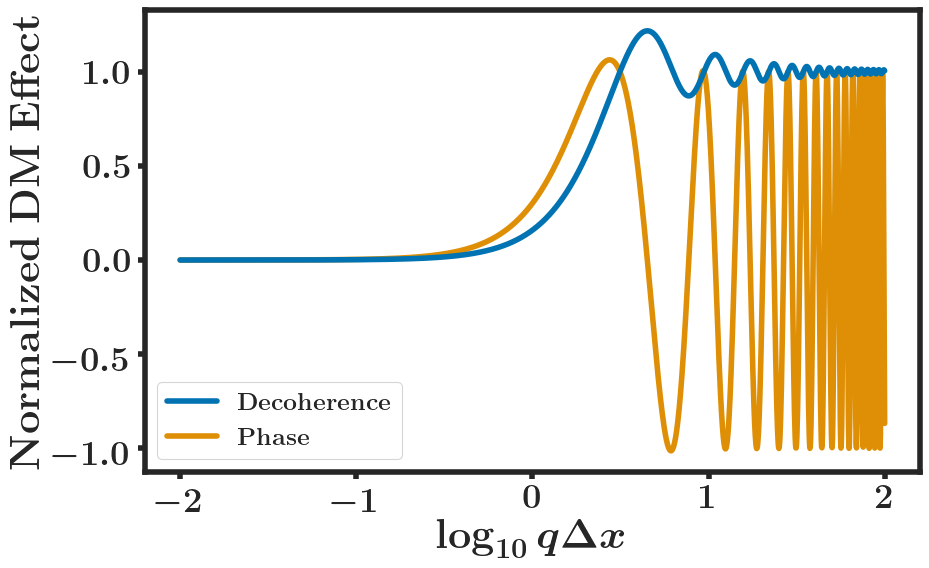

In [5]:
plot_phase_diagram_subplot()

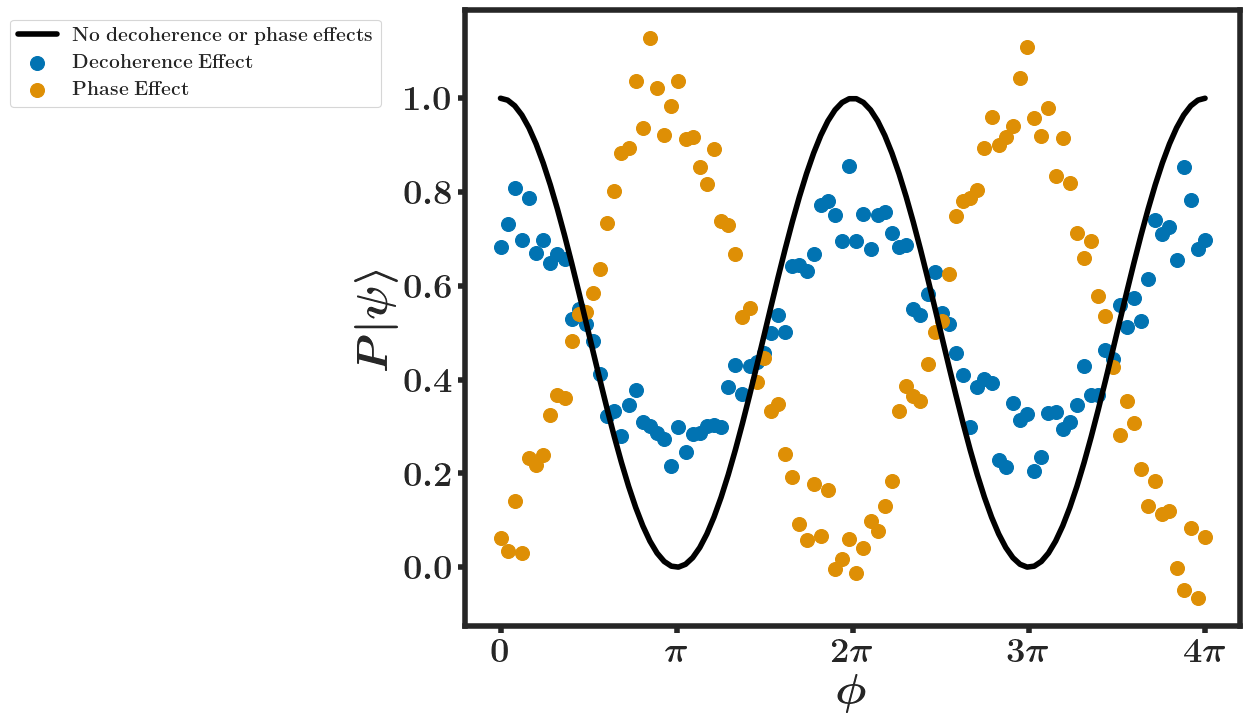

In [6]:
plot_fringe_cartoon()

# Fig. 2

In [7]:
def plot_exp(ax, exp, qmin=False, mphi_ratios=1.e-5, medtype='light', phase=False, multiplier=1.):
    if RECALC_LIMITS:
        get_lim(exp, qmin=qmin, mphi_ratios=mphi_ratios, medtype=medtype)
    ## load data
    try:
        fn = f'../results/limits/{exp}_{medtype[0]}'
        if medtype=='fixed_light':
            fn += f"_{int(-1.*np.log10(mphi_ratios))}"
        if phase:
            fn += "_phase.dat"
        else:
            fn += ".dat"
#         print(fn)
        dat = Table.read(fn, format='ascii.ecsv')
        if (medtype=='light') or (medtype=='fixed_light'):
            dat[f'sigma_{int(-1.*np.log10(mphi_ratios))}']
        else:
            dat[f'sigma']
    except KeyError:
        print("Can't find column. Looking for single mphi version.")
        fn = f'../results/limits/{exp}_{medtype[0]}_{int(-1.*np.log10(mphi_ratios))}.dat'
        dat = Table.read(fn, format='ascii.ecsv')
    except (IOSError, OSError):
        print("Can't find file. Re-running limits.")
        get_lim(exp, qmin=qmin, mphi_ratios=mphi_ratios, medtype=medtype)
        fn = f'../results/limits/{exp}_{medtype[0]}_{int(-1.*np.log10(mphi_ratios))}.dat'
        dat = Table.read(fn, format='ascii.ecsv')

    if phase:
        ls = 'dashed'
        label = None
    else:
        ls = 'solid'
        label = f'$\\rm{{{exp}}}$'
        
    if medtype=='heavy':
        alpha = 1.0
        sig = dat['sigma']
        maxlim = np.inf
        if exp == 'Pino':
            maxlim = 1.e-28
#         if (exp == 'MAQRO') and (phase==False):
#             ##numerical artifacts -- smooth.
#             mxss = np.logspace(-6,3,1000)
#             ax.loglog(mxss, spline_maq(dat['mx'], sig, mxss)*multiplier,
#                      c=cs[exps.index(exp)], ls=ls, lw=2, label=label, alpha = alpha)
#         else:
        ax.loglog(dat['mx'][sig<maxlim], sig[sig<maxlim]*multiplier, lw=2, 
                    c=cs[exps.index(exp)], ls=ls, label=label, alpha = alpha)
    else:
        alpha = 1.0
        ax.loglog(dat['mx'], dat[f'sigma_{int(-1.*np.log10(mphi_ratios))}']*multiplier, lw=2, 
                  c=cs[exps.index(exp)], ls=ls, label=label, alpha = alpha)

In [35]:
def plot_panel(ax, mpr, qmin=False, asym=False, legend=False, phase=False):
    for ex in exps:
        if ex == None:
            continue
        plot_exp(ax, ex, qmin=qmin, mphi_ratios=mpr, phase=False)
        if phase:
            plot_exp(ax, ex, qmin=qmin, mphi_ratios=mpr, phase=True)
    ## add text
    ax.text(0.85, 0.05,f'$m_{{\phi}} = 10^{{{int(np.log10(mpr))}}}m_{{\chi}}$',
             horizontalalignment='center', verticalalignment='center', 
             transform = ax.transAxes,fontsize=16)
    ## 0.15, 0.95
    ax.text(0.02, 0.11,r'$\Omega_\chi = 0.05\ \Omega_{\rm{DM}}$',
             horizontalalignment='left', verticalalignment='center', 
             transform = ax.transAxes,fontsize=16)
    ## 0.15, 0.89
    ax.text(0.02, 0.05,r'$y_{{\chi}} = \sqrt{4\pi}$',
             horizontalalignment='left', verticalalignment='center', 
             transform = ax.transAxes,fontsize=16)

    ## plot other limits
    if not asym:
        mphit = ffmphi[ffmphi<1.*u.MeV*mpr]
        ax.loglog(mphit*1./mpr, sigma_self(mphit*1./mpr, mphit), color='k')
        ax.fill_between(mphit*1./mpr, sigma_self(mphit*1./mpr, mphit), 1, facecolor='grey', 
                        alpha=0.5, hatch='X', edgecolor='k')

    mptypes = [ffmphi, rgbmphi, hbmphi, snmphi]
    yntypes = [ffyn, rgbyn, hbyn, snyn]
    hatches = [None, '|', 'X', '.']
    for mphi, yn, hatch in zip(mptypes, yntypes, hatches):
        sigma = yn_to_sigman(yn, mphi*1./mpr, mphi)
        ax.loglog(mphi*1./mpr, sigma, color='k')
        ax.fill_between(mphi*1./mpr, sigma, 1., color='k', alpha=0.3, hatch=hatch, facecolor='gray',
                       edgecolor='k')

    ax.loglog(10**HeNRdat['mx'], 20.*10**HeNRdat['sigma'], color='black', alpha=0.5)
    ax.text(3, 2.e-42, 'He NR', color='gray', rotation=-20)
    ax.loglog(10**Hephodat['mx'], 20.*10**Hephodat['sigma'], color='black', alpha=0.5, ls='dashed')
    ax.text(1.e-1, 2.e-40, 'He 2-phonon', color='gray', rotation=-37)
    

    if legend:
        ax.legend(loc='lower center', fontsize=12, ncol=1)
    ax.set_xlabel(r'$m_{\chi}~[\rm{MeV}]$');
    ax.set_ylabel(r'$\bar{\sigma}~[\rm{cm}^2]$');
    ax.set_xlim([1.e-5, 1.e3])
    ax.set_ylim([1.e-49, 1.e-25])
    if mpr == 1.e-10:
        ax.set_ylim([1.e-52, 1.e-32])

In [36]:
def plot_four_panel(rat1, rat2, rat3, rat4):
    f, ax = plt.subplots(2,2, figsize=(15,10))
    plot_panel(ax[0,0], rat1, qmin=False, asym=True, phase=True)
    mxss = np.logspace(-2, np.nanmax(np.log10(phonodark['mx'])), 1000)
    ax[0,0].loglog(mxss, spline_pd(phonodark['mx'], phonodark['sigma10'], mxss, s=0.1)*20., color='black',
             alpha=0.5, ls='dotted')
    ax[0,0].text(5.e-2, 9e-44*20., r'Al$_2$O$_3$~phonon', color='gray', rotation=-20)
    plot_panel(ax[0,1], rat2, asym=True, phase=True)
    ax[0,1].loglog(mxss, spline_pd(phonodark['mx'], phonodark['sigma7'], mxss, s=0.1)*20., color='black',
             alpha=0.5, ls='dotted')
    ax[0,1].text(5.e-2, 5e-44*20., r'Al$_2$O$_3$~phonon', color='gray', rotation=-20)
    plot_panel(ax[1,0], rat3, asym=True, phase=True)
    ax[1,0].loglog(mxss, spline_pd(phonodark['mx'], phonodark['sigma5'], mxss, s=0.1)*20., color='black',
             alpha=0.5, ls='dotted')
    ax[1,0].text(8.e-2, 3e-44*20., r'Al$_2$O$_3$~phonon', color='gray', rotation=-18)
    plot_panel(ax[1,1], rat4, asym=True, legend=True, phase=True)
    ax[1,1].loglog(mxss, spline_pd(phonodark['mx'], phonodark['sigma3'], mxss, s=0.1)*20., color='black',
             alpha=0.5, ls='dotted')
    ax[1,1].text(3.e-2, 5e-43*20., r'Al$_2$O$_3$~phonon', color='gray', rotation=0)
    f.tight_layout()
    plt.savefig(f'../results/reach_plot.pdf', dpi=450)

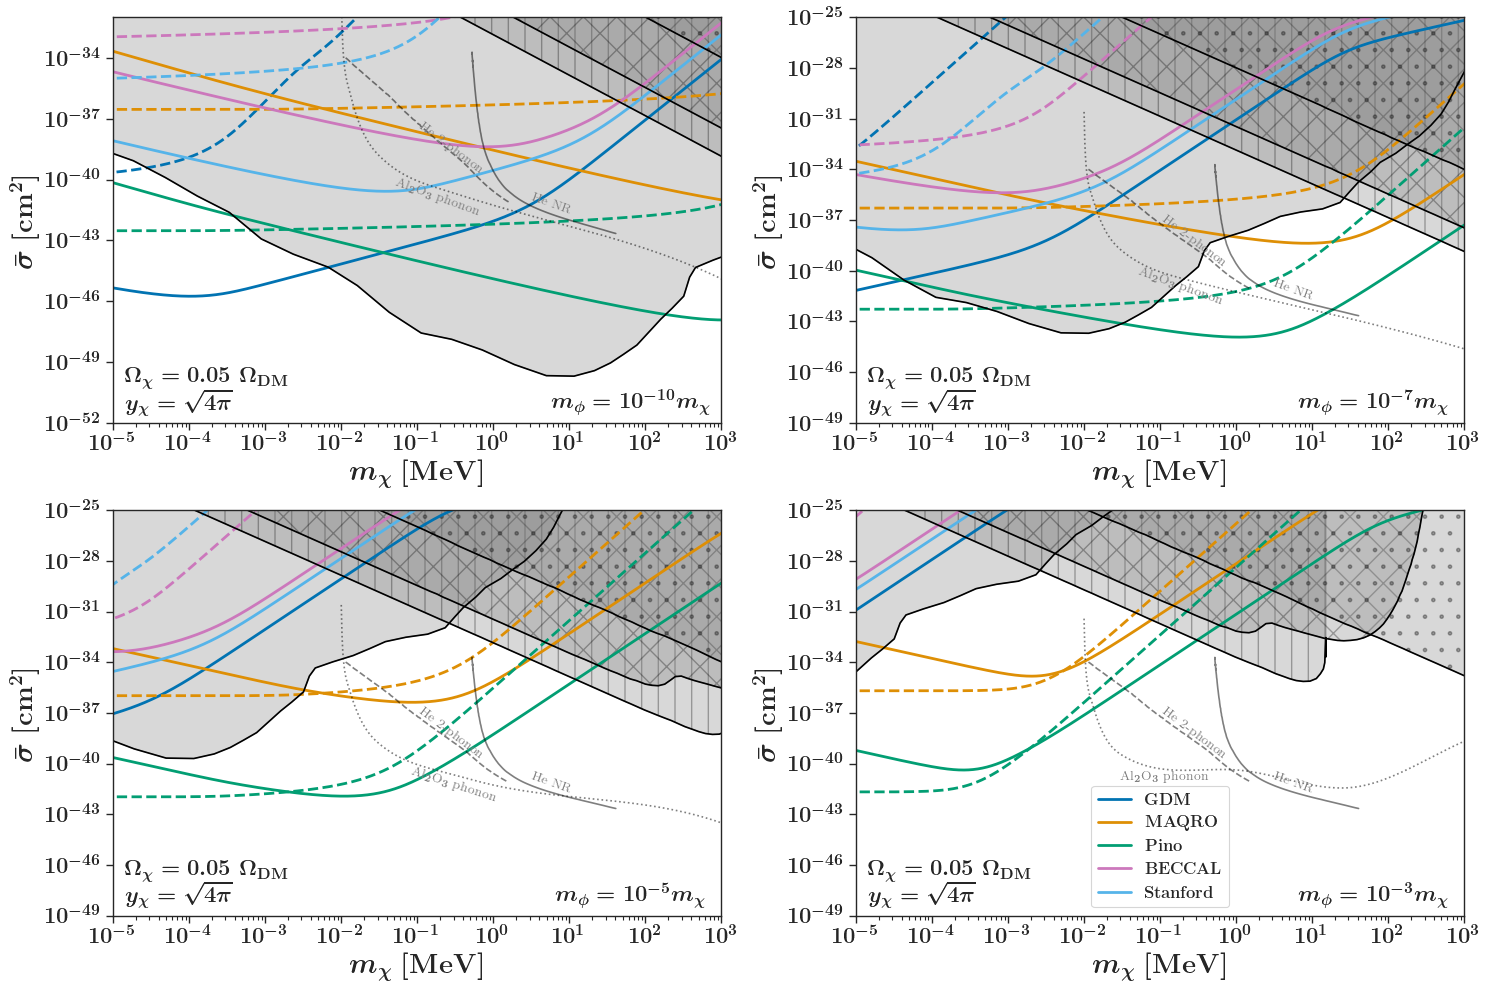

In [38]:
plot_four_panel(1.e-10, 1.e-7, 1.e-5, 1.e-3)

# Fig. 3

In [39]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [44]:
def plot_fixed_mphi(mphi):
    f, ax = plt.subplots(1,1, figsize=(10,6))

    for ex in exps:
        if ex == None:
            continue
        plot_exp(ax, ex,  mphi_ratios=mphi, medtype='fixed_light', phase=False)
        plot_exp(ax, ex,  mphi_ratios=mphi, medtype='fixed_light', phase=True)

    ## plot other limits
#     mptypes = [ffmphi, rgbmphi, hbmphi, snmphi]
#     yntypes = [ffyn, rgbyn, hbyn, snyn]
#     hatches = [None, '|', '-', 'X']
    mptypes = [ffmphi]
    yntypes = [ffyn]
    hatches = [None]
    for ynmphi, yn, hatch in zip(mptypes, yntypes, hatches):
        mxs = np.logspace(-6,3,len(yn))*u.MeV
        sigma = yn_to_sigman(yn[find_nearest(ynmphi, mphi)], mxs, mphi*u.MeV)
        ax.loglog(mxs, sigma, color='k')
        ax.fill_between(mxs, sigma, 1., edgecolor='k', facecolor='gray', alpha=0.3, hatch=hatch)

    

    ax.loglog(10**HeNRdat['mx'], 20*10**HeNRdat['sigma'], color='black', alpha=0.5)
    ax.text(1., 1.e-40, 'He NR', color='gray', rotation=-20)
    ax.loglog(10**Hephodat['mx'], 20*10**Hephodat['sigma'], color='black', alpha=0.5, ls='dashed')
    ax.text(1.e-1, 6.e-40, 'He 2-phonon', color='gray', rotation=-30)
    ax.plot(pd_fixedmphi_1eV['mx'], pd_fixedmphi_1eV['sigma']*20., color='black', alpha=0.5, ls='dotted')
    ax.text(5.e-2, 8e-42, r'Al$_2$O$_3$~phonon', color='gray', rotation=-15)
    
    ## text
    ax.text(0.1, 0.08,f'$m_{{\phi}} = {int(mphi*1.e6)}~\\rm{{eV}}$',
             horizontalalignment='center', verticalalignment='center', 
             transform = ax.transAxes,fontsize=16)
    ax.text(0.85, 0.95,r'$\Omega_\chi = 0.05\ \Omega_{\rm{DM}}$',
             horizontalalignment='center', verticalalignment='center', 
             transform = ax.transAxes,fontsize=16)
    ax.text(0.85, 0.89,r'$y_{{\chi}} = \sqrt{4\pi}$',
             horizontalalignment='center', verticalalignment='center', 
             transform = ax.transAxes,fontsize=16)
    

    plt.legend(loc='upper left', fontsize=15)
    plt.xlabel(r'$m_{\chi}~[\rm{MeV}]$');
    plt.ylabel(r'$\bar{\sigma}~[\rm{cm}^2]$');
    plt.xlim([1.e-5, 1.e3])
    plt.ylim([1.e-46, 1.e-22])

    plt.savefig(f'../results/reach_plot_fixedmphi_{mphi*1.e6}eV.pdf', dpi=450)


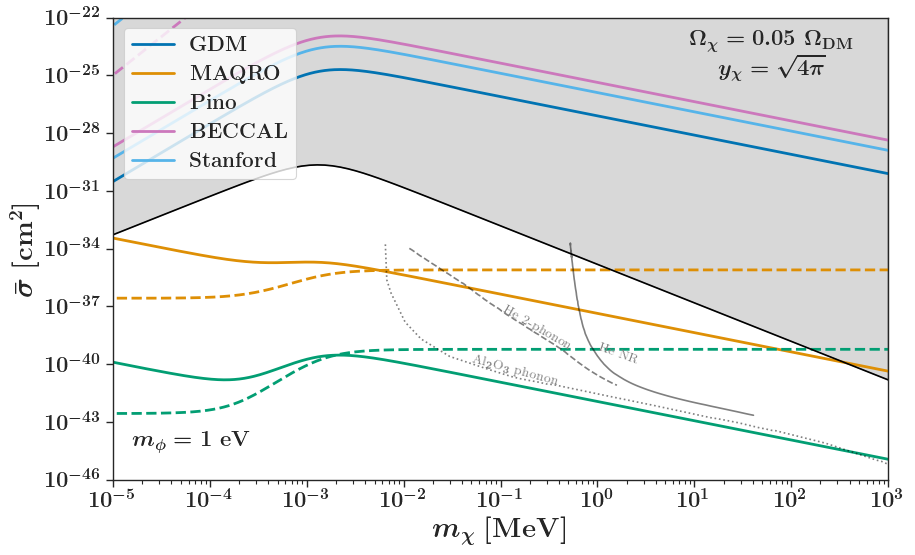

In [45]:
plot_fixed_mphi(1.e-6)

# Fig. 4

In [50]:
def plot_heavy(mpr=1.e-3):
    f, ax = plt.subplots(1,1, figsize=(10,6))
    for ex in exps:
        if ex == None:
            continue
        plot_exp(ax, ex, medtype='heavy', multiplier=1./20.)
        plot_exp(ax, ex, medtype='heavy', phase=True, multiplier=1./20.)
    
    ##20 factor because Omegax = OmegaDM
    
    
    ##SHe lines
    mxs = np.logspace(np.min(np.log10(heavy_HeNRdat['mx'])),np.max(np.log10(heavy_HeNRdat['mx'])), 100)
    ax.loglog(mxs, spline_he_heavy_nr(mxs),  color='black', alpha=0.5) 
    ax.text(10, 1.e-43, 'He NR', color='gray', rotation=30)
    ax.loglog(heavy_Hephodat['mx'], heavy_Hephodat['sigma'], color='black', alpha=0.5, ls='dashed')
    ax.text(5.e-2, 4.e-42, 'He 2-phonon', color='gray', rotation=-31)
    
    ##PD line
    mxs = np.logspace(-2, np.nanmax(np.log10(phonodark['mx'])), 1000)
#     ax.loglog(mxs, spline_pd(phonodark['mx'], phonodark['heavy']*1./20., mxs, s=0.5), color='black',
#              alpha=0.5, ls='dotted')
    ax.loglog(pd_heavy['mx'][12:], pd_heavy['sigma'][12:], color='black', alpha=0.5, ls='dotted')
    ax.text(2.e-2, 5e-44, r'Al$_2$O$_3$~phonon', color='gray')
    
    ax.text(0.89, 0.95,f'$m_{{\phi}} \gg 10^{{-3}} m_{{\chi}}$',
             horizontalalignment='center', verticalalignment='center', 
             transform = ax.transAxes,fontsize=16)
    ax.text(0.89, 0.89,r'$\Omega_\chi = \Omega_{\rm{DM}}$',
             horizontalalignment='center', verticalalignment='center', 
             transform = ax.transAxes,fontsize=16)
    plt.legend(loc='lower right', fontsize=12, ncol=2, framealpha=1.0)
    plt.xlabel(r'$m_{\chi}~[\rm{MeV}]$');
    plt.ylabel(r'$\bar{\sigma}~[\rm{cm}^2]$');
    plt.xlim([1.e-5, 1.e3])
    plt.ylim([1.e-48, 1.e-27])

    plt.savefig(f'../results/heavy_reach.pdf', dpi=450)

/var/folders/4m/f15lhwvs5_b_n0_3rkl4b2k00000gn/T/ipykernel_27917/3237954029.py:23: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax.loglog(pd_heavy['mx'][12:], pd_heavy['sigma'][12:], color='black', alpha=0.5, ls='dotted')


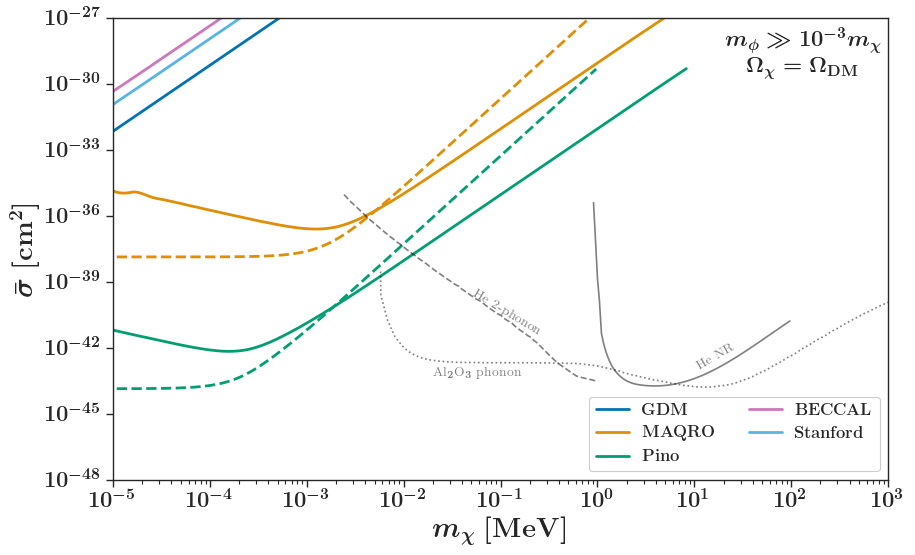

In [51]:
plot_heavy()

# Fig. 5

In [16]:
def plot_daily_mod():
    ## load data
    sperp =pd.read_csv("../results/daily_mod/sblueN.txt", names=['t', 's'], delimiter='\s+')
    spar = pd.read_csv("../results/daily_mod/sgreenN.txt", names=['t', 's'], delimiter='\s+')
    smix = pd.read_csv("../results/daily_mod/sorgN.txt", names=['t', 's'], delimiter='\s+')
    pperp =pd.read_csv("../results/daily_mod/phiblueN.txt", names=['t', 'phi'], delimiter='\s+')
    ppar = pd.read_csv("../results/daily_mod/phigreenN.txt", names=['t', 'phi'], delimiter='\s+')
    pmix = pd.read_csv("../results/daily_mod/phiorgN.txt", names=['t', 'phi'], delimiter='\s+')
    
    f, ax = plt.subplots(1,2, figsize=(20,6))
    
    ax[0].plot(sperp['t'], sperp['s'], lw=2, 
               label=r'$\mathbf{\Delta x} \perp \hat{\mathbf{g}}, \mathbf{\Delta x} \perp ( \hat{\mathbf{L}} \times \hat{\mathbf{g}})$')
    ax[0].plot(spar['t'], spar['s'], lw=2, 
               label=r'$\mathbf{\Delta x} \parallel \hat{\mathbf{g}}, \mathbf{\Delta x} \parallel ( \hat{\mathbf{L}} \times \hat{\mathbf{g}})$')
    ax[0].plot(smix['t'], smix['s'], lw=2, 
               label=r'$\mathbf{\Delta x} \perp \hat{\mathbf{g}}, \mathbf{\Delta x} \parallel ( \hat{\mathbf{L}} \times \hat{\mathbf{g}})$')
    
    ts = np.linspace(0, 24, 1000)
    ax[1].plot(ts, spline_modulation(pperp['t'], pperp['phi'], ts), lw=2, 
               label=r'$\mathbf{\Delta x} \perp \hat{\mathbf{g}}, \mathbf{\Delta x} \perp ( \hat{\mathbf{L}} \times \hat{\mathbf{g}})$')
    ax[1].plot(ts, spline_modulation(ppar['t'], ppar['phi'], ts), lw=2, 
               label=r'$\mathbf{\Delta x} \parallel \hat{\mathbf{g}}, \mathbf{\Delta x} \parallel ( \hat{\mathbf{L}} \times \hat{\mathbf{g}})$')
    ax[1].plot(ts, spline_modulation(pmix['t'], pmix['phi'], ts), lw=2, 
               label=r'$\mathbf{\Delta x} \perp \hat{\mathbf{g}}, \mathbf{\Delta x} \parallel ( \hat{\mathbf{L}} \times \hat{\mathbf{g}})$')
    
    
    ax[1].legend(loc="lower left", fontsize=14)
    
    ax[0].set_xlabel(r'$t~[\rm{hours}]$', fontsize=25)
    ax[1].set_xlabel(r'$t~[\rm{hours}]$', fontsize=25)
    
    ax[0].set_ylabel(r'$s(t)/s(0)$', fontsize=25)
    ax[1].set_ylabel(r'$\phi(t)/\phi(0)$', fontsize=25)
    
    plt.tight_layout()
    plt.savefig(f'../results/daily_mod.pdf', dpi=450)

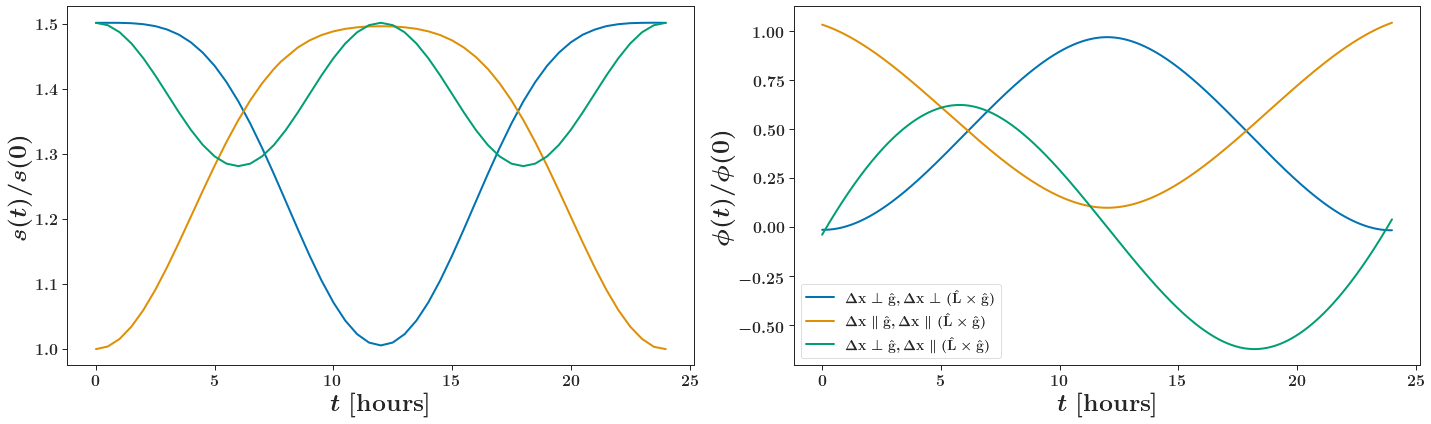

In [17]:
plot_daily_mod()

# Extras

In [18]:
def plot_specific_mphi(mpr, plot_noqmin=True):
    f, ax = plt.subplots(1,1, figsize=(10,6))

    for ex in exps:
        if ex == None:
            continue
        plot_exp(ax, ex)
        if plot_noqmin:
            plot_exp(ax, ex, qmin=False)
    ## text indicating mediator mass
    plt.text(0.15, 0.05,f'$m_{{\phi}} = 10^{{{int(np.log10(mpr))}}}m_{{\chi}}$',
             horizontalalignment='center', verticalalignment='center', 
             transform = ax.transAxes,fontsize=16)

    ## plot other limits
    ## self-interaction
    plt.loglog(ffmphi*1./mpr, sigma_self(ffmphi*1./mpr, ffmphi), color='k')
    plt.fill_between(ffmphi*1./mpr, sigma_self(ffmphi*1./mpr, ffmphi), 1, color='k', alpha=0.3, hatch='X')
    ffsigma = yn_to_sigman(ffyn, ffmphi*1./mpr, ffmphi)
    plt.loglog(ffmphi*1./mpr, ffsigma, color='k')
    plt.fill_between(ffmphi*1./mpr, ffsigma, 1., color='k', alpha=0.3)

    plt.loglog(10**HeNRdat['mx'], 10**HeNRdat['sigma'], color='black', alpha=0.5)
    plt.text(3, 1.e-43, 'He NR', color='gray', rotation=-20)
    plt.loglog(10**Hephodat['mx'], 10**Hephodat['sigma'], color='black', alpha=0.5, ls='dashed')
    plt.text(1.e-1, 9.e-44, 'He 2-phonon', color='gray', rotation=-42)

    plt.legend(loc='upper left', fontsize=15)
    plt.xlabel(r'$m_{\chi}~[\rm{MeV}]$');
    plt.ylabel(r'$\bar{\sigma}_n~[\rm{cm}^2]$');
    plt.xlim([1.e-9, 1.e3])
    plt.ylim([1.e-45, 1.e-20])

    plt.savefig(f'../results/reach_plot_{int(-1.*np.log10(mpr))}.pdf')

In [19]:
print(exps)
def mx_est(N, deltax):
#     return np.sqrt(N)/deltax
    return 1./(np.sqrt(N)*deltax)
def get_all():
    for ex in exps:
        if ex==None:
            continue
        class_ = getattr(x, ex)
        exp = class_()
        print(mx_est(exp.N, exp.deltax))

['GDM', 'MAQRO', 'Pino', None, 'BECCAL']
